In [1]:
import warnings
warnings.filterwarnings("ignore")

## 企鹅数据集分析

In [2]:
import pandas as pd
data=pd.read_csv("./penguins_size.csv")
data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,MALE
1,Adelie,Torgersen,39.5,17.4,186,3800,FEMALE
2,Adelie,Torgersen,40.3,18.0,195,3250,FEMALE
3,Adelie,Torgersen,36.7,19.3,193,3450,FEMALE
4,Adelie,Torgersen,39.3,20.6,190,3650,MALE


该数据集包含来自帕尔默群岛 3 个岛屿的 3 种不同种类的企鹅，分别是 Adelie、Chinstrap 和 Gentoo。其中，属性包括鸟喙上脊的长度、深度，脚蹼长度，体重以及性别。

### 逻辑斯蒂回归 

（1） **特征选择**：希望得到企鹅物种类别的推断，island及sex信息属于无关信息，故在之后的数据中进行删除。同时，为了避免过拟合所带来的影响，选取相关系数较高的特征作为自变量。由于探讨的为类型数据与数值数据之间的相关性，故采用Cramer's V相关系数。

In [3]:
data = data.dropna() #数据清洗
mapping = {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}
data['species'] = data['species'].map(mapping) #将物种类别字符型转换为数值型
data = data.drop(['sex','island'], axis=1)
import numpy as np
from scipy.stats import chi2_contingency
# 计算Cramer's V相关系数
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
correlation_matrix = pd.DataFrame(index=data.columns, columns=['species'])
for column in data.columns:
    if column != 'species':
        correlation_matrix.loc[column, 'species'] = cramers_v(data['species'], data[column])
print(correlation_matrix)

                    species
species                 NaN
culmen_length_mm   0.444212
culmen_depth_mm    0.567331
flipper_length_mm  0.630403
body_mass_g        0.514712


从相关系数矩阵中可以发现，属性flipper_length_mm及culmen_depth_mm的相关系数较高，故选取这两种属性作为X特征。

In [4]:
X = data[['flipper_length_mm','culmen_depth_mm']]
y = data['species']

(2) **训练集与测试集的拆分**：

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

In [6]:
# 可视化代码
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none', 
                    edgecolor='yellow',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

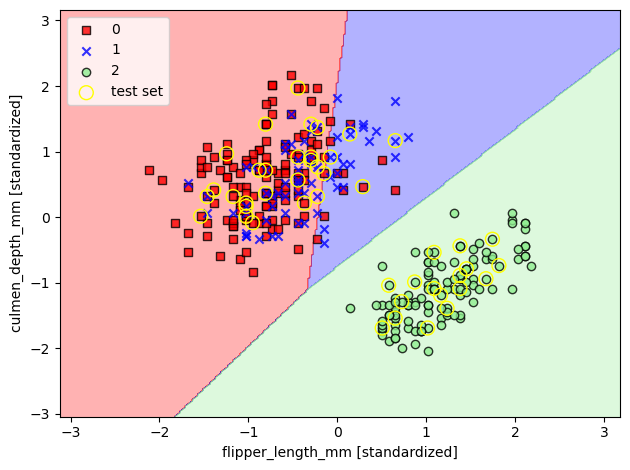

In [7]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('flipper_length_mm [standardized]')
plt.ylabel('culmen_depth_mm [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

可以看出，Gentoo的类别区分较为优秀，但Adelie及Chinstra类别区别较为模糊。

In [8]:
from sklearn.metrics import accuracy_score, classification_report
y_pred=lr.predict(X_test_std[:,:])
accuracy = accuracy_score(y_test, y_pred)
print("整体正确率：", accuracy)
classes = np.unique(y_test)  
for cls in classes:
    idx = np.where(np.array(y_test) == cls)  
    cls_accuracy = accuracy_score(np.array(y_test)[idx], np.array(y_pred)[idx])
    print("类别{}的正确率：{}".format(cls, cls_accuracy))
report = classification_report(y_test, y_pred)
print(report)

整体正确率： 0.84
类别0的正确率：0.9772727272727273
类别1的正确率：0.25
类别2的正确率：1.0
              precision    recall  f1-score   support

           0       0.74      0.98      0.84        44
           1       0.83      0.25      0.38        20
           2       1.00      1.00      1.00        36

    accuracy                           0.84       100
   macro avg       0.86      0.74      0.74       100
weighted avg       0.85      0.84      0.81       100



可以看出，整体正确率较高，然而1类（Chinstra）的召回率较低，猜想可能是因为支持度不够，样本量（20）较小的原因。

### 层次聚类

层次聚类为无监督学习模型，故先去除带有标签的列。

In [9]:
data = data.drop('species', axis=1)
data

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181,3750
1,39.5,17.4,186,3800
2,40.3,18.0,195,3250
3,36.7,19.3,193,3450
4,39.3,20.6,190,3650
...,...,...,...,...
328,47.2,13.7,214,4925
329,46.8,14.3,215,4850
330,50.4,15.7,222,5750
331,45.2,14.8,212,5200


In [10]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 0
 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1
 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0
 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 2 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 2 2 0 0 2 2 2 0 2 0 0 0 2 0 0 2 0
 0 2 0 0 0 2 0 2 0 2 0 2 0 2 0 2 0 2 2 2 2 2 2 0 2 2 0 0 2 0 2 0 2 0 2 0 2
 0 2 0 0 0 2 0 2 0 2 0 2 0 2 0 2 2 2 0 2 0 0 2 0 0 0 2 0 2 0 2 2 0 0 2 0 0]


计算误分类的比例：

In [11]:
import numpy as np
def compare_vectors(vector1, vector2):  
    num_elements = len(vector1)
    num_mismatch = np.sum(vector1 != vector2)
    mismatch_ratio = num_mismatch / num_elements
    return mismatch_ratio
mismatch_ratio = compare_vectors(labels, y)
print("误分类比例：", mismatch_ratio)

误分类比例： 0.6456456456456456


可以看出，层次聚类的误分类比例高达$64\%$，可见效果非常不佳，原因之一可能是层次聚类分类的标号与原标签的标号并不等价，故在此将标号进行遍历，共$2*3=6$种，取误分类比例最小的值作为最终结果。

In [12]:
labels = np.where(labels == 1, 2, np.where(labels == 2, 1, labels))
mismatch_ratio = compare_vectors(labels, y)
print("误分类比例：", mismatch_ratio)

误分类比例： 0.8588588588588588


In [13]:
labels = np.where(labels == 0, 1, np.where(labels == 2, 0, 2))
mismatch_ratio = compare_vectors(labels, y)
print("误分类比例：", mismatch_ratio)

误分类比例： 0.42342342342342343


In [14]:
labels = np.where(labels == 0, 2, np.where(labels == 2, 0, labels))
mismatch_ratio = compare_vectors(labels, y)
print("误分类比例：", mismatch_ratio)

误分类比例： 0.8648648648648649


In [15]:
lables = np.where(labels == 1, 2, np.where(labels == 2, 0, 1))
mismatch_ratio = compare_vectors(labels, y)
print("误分类比例：", mismatch_ratio)

误分类比例： 0.8648648648648649


In [16]:
labels = np.where(labels == 1, 0, np.where(labels == 0, 1, labels))
mismatch_ratio = compare_vectors(labels, y)
print("误分类比例：", mismatch_ratio)

误分类比例： 0.8588588588588588


从中可以看出，误分类比例最低的值为$42.34\%$，依然较高，用层次聚类效果不佳，原因可能是忽略了标签信息，浪费了宝贵资源，选用无监督学习模型，同时数据内在结构间的关联性并没有特别强，因而导致这个结果。

### 数据分布可视化

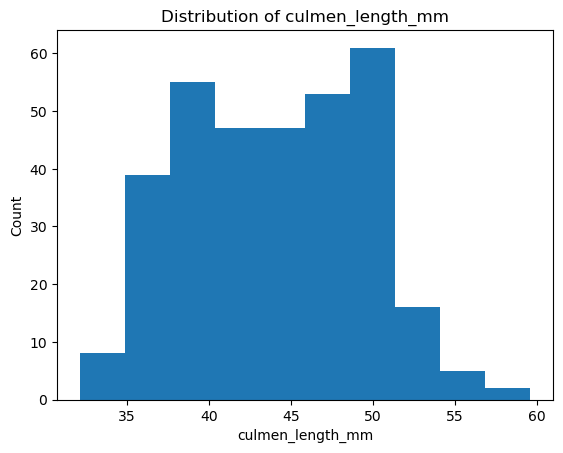

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据集
df = pd.read_csv('penguins_size.csv')
# 绘制culmen_length_mm的直方图
plt.hist(df['culmen_length_mm'], bins=10)
plt.xlabel('culmen_length_mm')
plt.ylabel('Count')
plt.title('Distribution of culmen_length_mm')
plt.show()

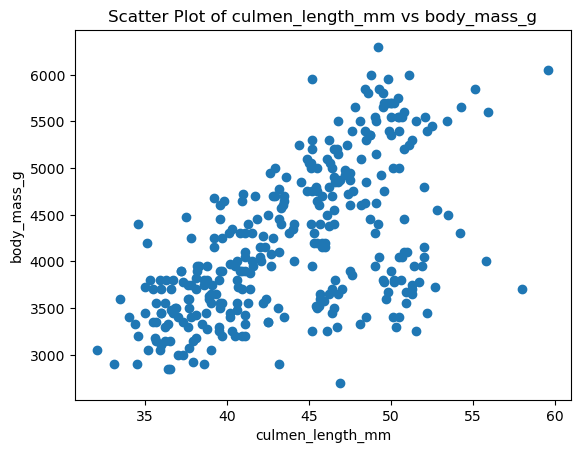

In [18]:
# 绘制culmen_length_mm和body_mass_g之间的散点图
plt.scatter(df['culmen_length_mm'], df['body_mass_g'])
plt.xlabel('culmen_length_mm')
plt.ylabel('body_mass_g')
plt.title('Scatter Plot of culmen_length_mm vs body_mass_g')
plt.show()

似乎较难直接找到有价值的信息，需要对数据进行进一步处理

### 使用PCA降维

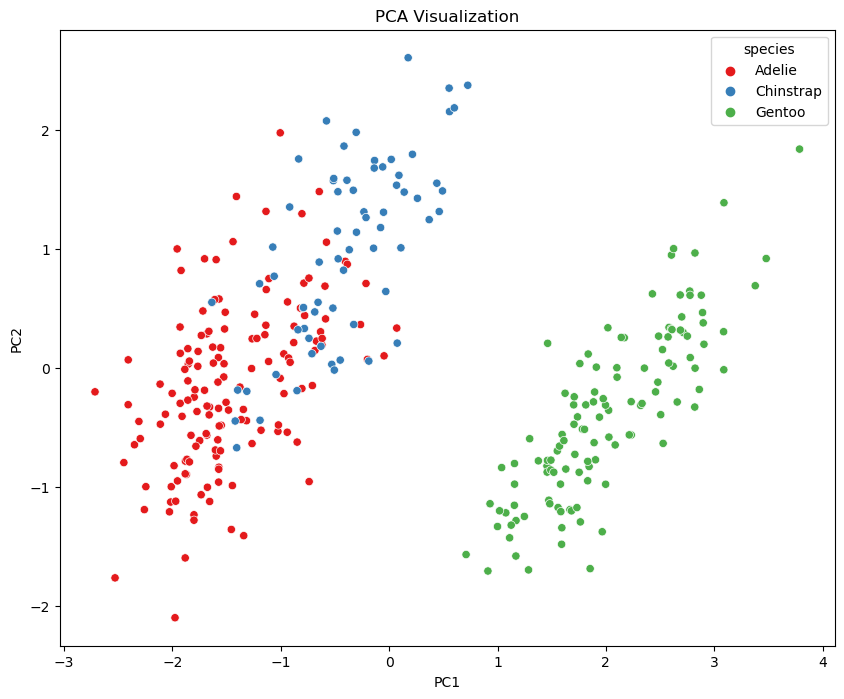

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# 读取数据集
df = pd.read_csv('penguins_size.csv')

# 选择要用于降维的特征列
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

# 标准化特征
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# 创建PCA对象，并指定要保留的主成分数量
pca = PCA(n_components=2)

# 对特征进行降维
principal_components = pca.fit_transform(scaled_features)

# 创建新的DataFrame，其中包含降维后的主成分和对应的标签
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['species'] = df['species']

# 绘制降维后的数据可视化
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='species', data=pca_df, palette='Set1')
plt.title('PCA Visualization')
plt.show()

可以和之前类似的结论：Gentoo的类别区分较为优秀，但Adelie及Chinstra类别区别较为模糊。

## 高斯混合噪声数据


In [20]:
import numpy as np
X = np.load('X.npy')
Y = np.load('Y.npy')


该数据集为样本数据量为500个的五元高斯混合噪声数据，聚类中心的个数为5，数据集的标准差为0.2。X.npy数据维度为（500，5）表示高斯噪声数据，y.npy维度为（500，）表示聚类中心。


### 使用TSNE进行降维

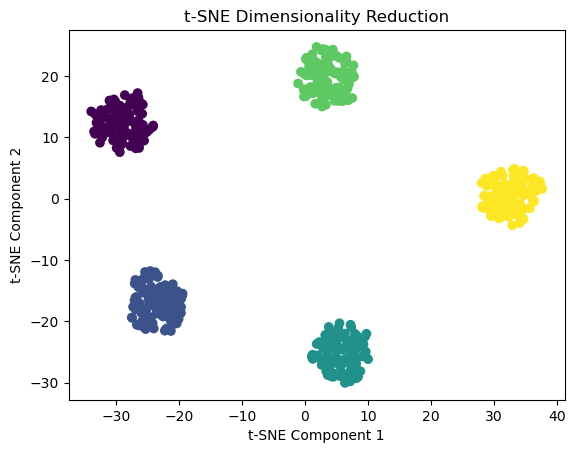

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 读取数据
X = np.load('X.npy')
y = np.load('y.npy')

# 创建t-SNE对象并进行降维
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# 可视化降维结果
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Dimensionality Reduction')
plt.show()

### 使用KNN算法进行分类

[0 2 3 4 0 0 4 0 2 0 3 3 0 4 1 4 0 4 0 4 3 1 4 3 3 1 0 0 1 0 4 1 3 0 2 1 4
 4 2 2 1 3 0 2 0 4 2 1 0 1 0 3 2 4 0 2 0 3 0 1 4 4 1 3 2 2 1 2 4 0 2 1 4 0
 2 0 4 4 3 3 4 0 3 3 4 3 2 1 2 1 2 1 3 1 1 2 3 0 3 3]
准确率： 1.0


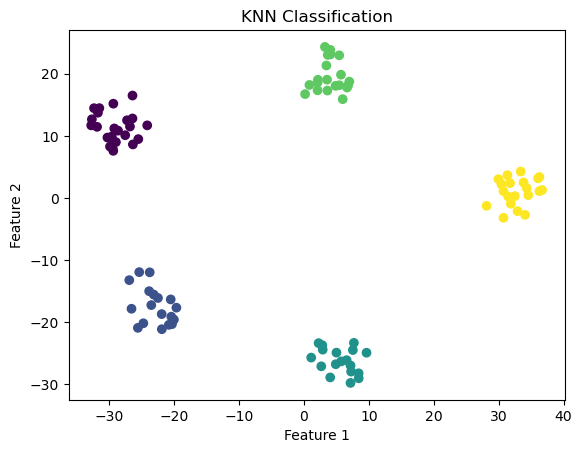

In [22]:

from sklearn.neighbors import KNeighborsClassifier
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=0.2, random_state=42)

# 创建K近邻分类器对象
knn = KNeighborsClassifier(n_neighbors=5)

# 在训练集上训练分类器
knn.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = knn.predict(X_test)
print(y_pred)
# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print("准确率：", accuracy)

# 可视化结果
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KNN Classification')
plt.show()

可以发现knn算法的分类准确率较高，效果很好

### K-means聚类

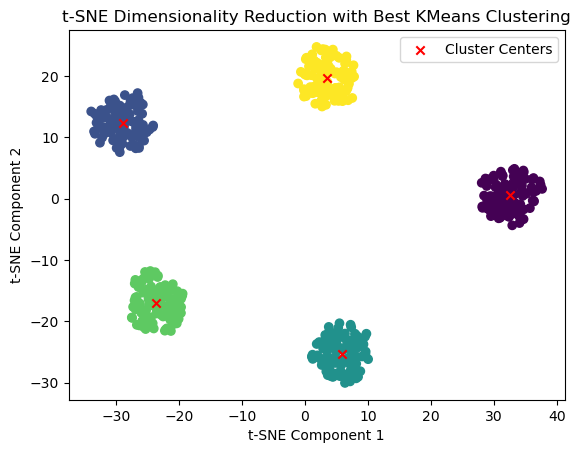

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# 定义不同聚类中心数量的范围
num_clusters_range = range(2, 10)

# 初始化评估指标列表
scores = []
# 初始化最佳评估指标和最佳聚类结果
best_score = -1
best_kmeans = None
# 遍历不同聚类中心数量
for num_clusters in num_clusters_range:
    # 创建KMeans对象并进行聚类
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_tsne)
    labels = kmeans.labels_
    
    # 计算轮廓系数
    score = silhouette_score(X_tsne, labels)
    
    # 添加评估指标到列表中
    scores.append(score)
    if score > best_score:
        best_score = score
        best_kmeans = kmeans
# 获取最佳聚类结果的标签和聚类中心
best_labels = best_kmeans.labels_
best_centers = best_kmeans.cluster_centers_

# 可视化最佳聚类结果和聚类中心
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=best_labels, cmap='viridis')
plt.scatter(best_centers[:, 0], best_centers[:, 1], marker='x', color='red', label='Cluster Centers')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Dimensionality Reduction with Best KMeans Clustering')
plt.legend()
plt.show()

测试多个聚类中心数量后发现，选择5效果最好，结果如上图

### 可视化轮廓系数随聚类中心数变化的图像

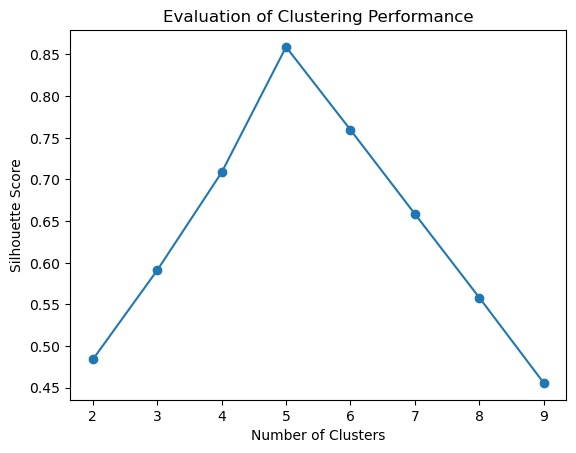

In [24]:
# 绘制折线图
plt.plot(num_clusters_range, scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Evaluation of Clustering Performance')
plt.show()

容易发现聚类中心数量取5时效果最好，和数据生成方式的理论结果一致。